# Autodrive

Keep an autodrive car walking between two white lines. 

In [37]:
%matplotlib inline
import keras
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import tensorflow as tf
import os
import urllib
import urllib.request
import pickle
import requests
import sys
import matplotlib.pyplot
import numpy as np
import sklearn
import pandas as pd

In [41]:
datapath = os.getcwd() + '\indoor_lanes.pkl'
if os.path.exists(datapath):
    print('Using local data file.')
else:
    link = "https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl"
    file_name = "indoor_lanes.pkl"
    with open(file_name, "wb") as f:
        print("Downloading %s" % file_name)
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                sys.stdout.flush()
    print('Data file downloaded.')
with open(datapath, 'rb') as f:
        X, Y = pickle.load(f)

Using local data file.


In [7]:
'If downloading from web, ''
'the following bar will display the progress of downloading (443 MB)'

[==================================================]

X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)


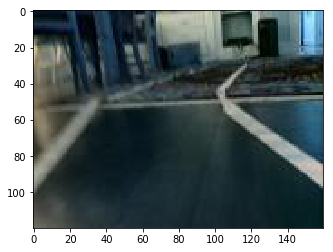

In [22]:
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
matplotlib.pyplot.imshow(X[210])

In [42]:
#X, Y = sklearn.utils.shuffle(X, Y)
def unison_shuffled_copies(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_copies(X,Y)

len(shuffled_X)

cutoff_8 = int(len(X)*.8) #80% used for training
cutoff_9 = int(len(X)*.9) #10% used for test

Xtrain, Ytrain = shuffled_X[:cutoff_8], shuffled_Y[:cutoff_8]
Xval, Yval = shuffled_X[cutoff_8 :cutoff_9], shuffled_Y[cutoff_8:cutoff_9]
Xtest, Ytest = shuffled_X[cutoff_9:], shuffled_Y[cutoff_9:]

len(Xtrain)+len(Xval)+len(Xtest)

7892

## Drive model

Input: 120x160 image
Output: steering (-90 to 90 degrees)
Reference: https://github.com/otaviogood/carputer

NOTE: there is no input such as last steering
Note2: No output of throttle value


In [43]:
img_in = Input(shape=(120, 160, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 118, 158, 8)       224       
_________________________________________________________________
activation_5 (Activation)    (None, 118, 158, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 77, 16)        1168      
_________________________________________________________________
activation_6 (Activation)    (None, 57, 77, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 38, 16)        0         
__________

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`
  after removing the cwd from sys.path.
C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
  
C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  if sys.path[0] == '':
C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


## Train the model

Only 4 epoches used

In [44]:
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

model.fit(Xtrain, Ytrain, batch_size=64, nb_epoch=4, validation_data=(Xval, Yval), callbacks=callbacks_list)

C:\Users\10\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 6313 samples, validate on 789 samples
Epoch 1/4
6313/6313 [==============================] - 51s 8ms/step - loss: 24088.0163 - val_loss: 729.2715

Epoch 00001: val_loss improved from inf to 729.27155, saving model to C:\Users\10/best_autopilot.hdf5
Epoch 2/4
6313/6313 [==============================] - 49s 8ms/step - loss: 572.5188 - val_loss: 562.4535

Epoch 00002: val_loss improved from 729.27155 to 562.45347, saving model to C:\Users\10/best_autopilot.hdf5
Epoch 3/4
6313/6313 [==============================] - 55s 9ms/step - loss: 455.2522 - val_loss: 473.2943

Epoch 00003: val_loss improved from 562.45347 to 473.29428, saving model to C:\Users\10/best_autopilot.hdf5
Epoch 4/4
6313/6313 [==============================] - 60s 10ms/step - loss: 401.9771 - val_loss: 436.8691

Epoch 00004: val_loss improved from 473.29428 to 436.86905, saving model to C:\Users\10/best_autopilot.hdf5


## Valiadation 

Show the scatter plot of actual vs predicted results. 

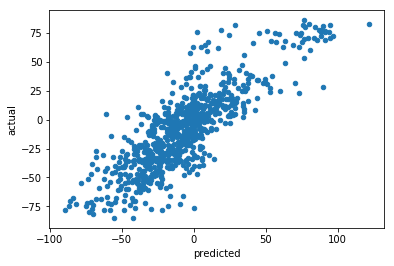

In [45]:
model = load_model(model_path)
test_P = model.predict(Xtest)
test_P = test_P.reshape((test_P.shape[0],)) 
df = pd.DataFrame({'predicted':test_P, 'actual':Ytest})
ax = df.plot.scatter('predicted', 'actual')

Text(0, 0.5, 'steering angle')

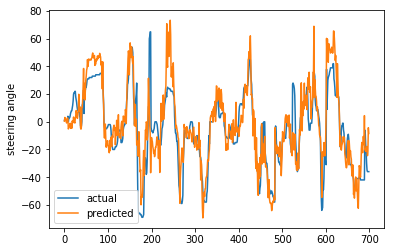

In [46]:
P = model.predict(X[:700])
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle")